## Import libraries

In [1]:
import pandas as pd

## Read dataset

In [2]:
df= pd.read_csv('./datasets/upworthy-archive-exploratory-packages-03.12.2020.csv')
print(df.dtypes)
df.head()

Unnamed: 0                int64
created_at               object
updated_at               object
clickability_test_id     object
excerpt                  object
headline                 object
lede                     object
slug                     object
eyecatcher_id            object
impressions               int64
clicks                    int64
significance            float64
first_place                bool
winner                     bool
share_text               object
square                   object
test_week                 int64
dtype: object


,Unnamed: 0,created_at,updated_at,clickability_test_id,excerpt,headline,lede,slug,eyecatcher_id,impressions,clicks,significance,first_place,winner,share_text,square,test_week
0,0,2014-11-20 06:43:16.005,2016-04-02 16:33:38.062,546d88fb84ad38b2ce000024,Things that matter. Pass 'em on.,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",theyre-being-called-walmarts-worst-nightmare-a...,546d6fa19ad54eec8d00002d,3052,150,100.0,True,True,Anyone who's ever felt guilty about shopping a...,NaN,201446
1,1,2014-11-20 06:43:44.646,2016-04-02 16:25:54.021,546d88fb84ad38b2ce000024,Things that matter. Pass 'em on.,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",theyre-being-called-walmarts-worst-nightmare-a...,546d6fa19ad54eec8d00002d,3033,122,14.0,False,False,Walmart is getting schooled by another retaile...,NaN,201446
2,2,2014-11-20 06:44:59.804,2016-04-02 16:25:54.024,546d88fb84ad38b2ce000024,Things that matter. Pass 'em on.,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",theyre-being-called-walmarts-worst-nightmare-a...,546d6fa19ad54eec8d00002d,3092,110,1.8,False,False,Walmart may not be crapping their pants over t...,NaN,201446
3,3,2014-11-20 06:54:36.335,2016-04-02 16:25:54.027,546d902c26714c6c44000039,Things that matter. Pass 'em on.,This Is What Sexism Against Men Sounds Like,<p>DISCLOSURE: I'm a dude. I have cried on mul...,this-is-what-sexism-against-men-sounds-like-am...,546bc55335992b86c8000043,3526,90,4.1,False,False,"If you ever wondered, ""but what about the men?...",NaN,201446
4,4,2014-11-20 06:54:57.878,2016-04-02 16:31:45.671,546d902c26714c6c44000039,Things that matter. Pass 'em on.,This Is What Sexism Against Men Sounds Like,<p>DISCLOSURE: I'm a dude. I have cried on mul...,this-is-what-sexism-against-men-sounds-like-am...,546d900426714cd2dd00002e,3506,120,100.0,True,False,"If you ever wondered, ""but what about the men?...",NaN,201446


In [3]:
df= df[['headline', 'clicks']]
df.head()
df.shape

(22666, 2)

In [4]:
df = (df.groupby('headline')['clicks'].mean()).to_frame(name = "clicks_mean").reset_index()
df.head()
df.shape
# Usar agg para obtener la moda de la columna winner

(12387, 2)

## Prepare Data

In [5]:
from nltk.tokenize import word_tokenize

### Split into Words

In [6]:
df['headline_words'] = df['headline'].apply(lambda word: word_tokenize(word))

In [7]:
df['headline_words'][0]

['A',
 'Bunch',
 'Of',
 'Middle',
 'Schoolers',
 'Actually',
 'Raised',
 'Their',
 'Hands',
 'And',
 'Volunteered',
 'For',
 'Something',
 '?',
 '!']

### Filter Out Punctuation

In [8]:
df['headline_punctuation'] = df['headline_words'].apply(lambda tokens: [word for word in tokens if word.isalpha()])

In [9]:
df['headline_punctuation'][0]

['A',
 'Bunch',
 'Of',
 'Middle',
 'Schoolers',
 'Actually',
 'Raised',
 'Their',
 'Hands',
 'And',
 'Volunteered',
 'For',
 'Something']

### Filter out Stop Words

#### Make words lower

In [10]:
df['headline_lower'] = df['headline_punctuation'].apply(lambda tokens: [w.lower() for w in tokens])

In [11]:
df['headline_lower'][0]

['a',
 'bunch',
 'of',
 'middle',
 'schoolers',
 'actually',
 'raised',
 'their',
 'hands',
 'and',
 'volunteered',
 'for',
 'something']

#### Filter out stop words

In [12]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')


In [13]:
df['headline_stopwords'] = df['headline_lower'].apply(lambda tokens: [w for w in tokens if not w in stop_words])

In [14]:
df['headline_stopwords'][0]

['bunch',
 'middle',
 'schoolers',
 'actually',
 'raised',
 'hands',
 'volunteered',
 'something']

### Stem words

In [15]:
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

In [16]:
df['headline_stemmed'] = df['headline_stopwords'].apply(lambda tokens: [porter.stem(word) for word in tokens])

In [17]:
df['headline_stemmed'][0]

['bunch', 'middl', 'schooler', 'actual', 'rais', 'hand', 'volunt', 'someth']

### Max lenght of tokens

In [18]:
df['headline_len'] = df['headline_stemmed'].apply(lambda tokens: len(tokens))
df['headline_len'].max()

14

### Train Model

In [19]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 10000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 30
# This is fixed.
EMBEDDING_DIM = 50

In [20]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.metrics import RootMeanSquaredError
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [21]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df['headline_stopwords'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9505 unique tokens.


In [32]:
X = tokenizer.texts_to_sequences(df['headline_stopwords'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

array([[ 170,  534, 4254, ...,    0,    0,    0],
       [3473,  336,  396, ...,    0,    0,    0],
       [1094, 2504,   11, ...,    0,    0,    0],
       ...,
       [   4,  683,  459, ...,    0,    0,    0],
       [  27,  482,  113, ...,    0,    0,    0],
       [   9, 4081,   48, ...,    0,    0,    0]])

In [23]:
y = df['clicks_mean'].values

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape

(8670, 30)

In [33]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# Last layer
model.add(Dense(1, activation='linear'))

opt = Adam(learning_rate=0.06)

model.compile(loss='mean_squared_error', optimizer=opt, metrics=[RootMeanSquaredError()])

In [34]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 50)            500000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 560,501
Trainable params: 560,501
Non-trainable params: 0
_________________________________________________________________


In [35]:
epochs = 10
batch_size = 64

In [36]:
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)])

C:\Users\jonat\anaconda3\envs\ml\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 7803 samples, validate on 867 samples
Epoch 1/10
7803/7803 [==============================] - 9s 1ms/step - loss: 2366.1331 - root_mean_squared_error: 48.6429 - val_loss: 2287.1886 - val_root_mean_squared_error: 47.8246
Epoch 2/10
7803/7803 [==============================] - 8s 1ms/step - loss: 2243.9872 - root_mean_squared_error: 47.3707 - val_loss: 2293.8430 - val_root_mean_squared_error: 47.8941
Epoch 3/10
7803/7803 [==============================] - 8s 1ms/step - loss: 2242.1299 - root_mean_squared_error: 47.3511 - val_loss: 2283.2935 - val_root_mean_squared_error: 47.7838
Epoch 4/10
7803/7803 [==============================] - 8s 1ms/step - loss: 2241.9158 - root_mean_squared_error: 47.3489 - val_loss: 2283.2708 - val_root_mean_squared_error: 47.7836
Epoch 5/10
7803/7803 [==============================] - 9s 1ms/step - loss: 2244.3163 - root_mean_squared_error: 47.3742 - val_loss: 2282.3973 - val_root_mean_squared_error: 47.7744
Epoch 6/10
7803/7803 [=====================

In [30]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Root mean squared error: {:0.3f}'.format(accr[0], accr[1]))

3717/3717 [==============================] - 1s 341us/step
Test set
  Loss: 1910.599
  Root mean squared error: 43.710


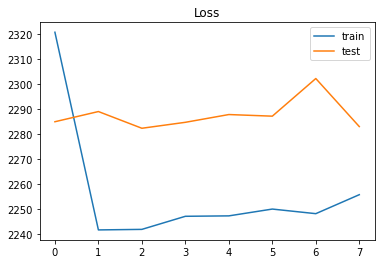

In [31]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();